In [1]:
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy

print (sys.version)

3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]


In [33]:
#setup
#tau: conformal time, a: scale factor, k: wavenumber (comoving)
#using natural units, hbar = c = 1, working in mpc

#constants
c = 3 * 1e8
h_0 = 0.7 
H_0 = h_0 * (1e5 / c) #maggiore, eq 17.5. units: mpc^-1

Omega_R = 4.184 * 1e-5 * (h_0 ** -2) #maggiore 17.79
Omega_M = 0.3 #maggiore 17.80
Omega_L = 1 - Omega_R - Omega_M #see section below maggiore 17.80
# Lambda = (1 / 3.24078) * 1e-6 #from wikipedia (converted), units: mpc^-2

#RD/MD equilibrium, maggiore values
a_eq = Omega_R / Omega_M #maggiore 17.83 (note: turner paper uses Omega_R)
# tau_0 = 2 / H_0 #from turner paper
tau_0 = 0.879 * 2 / (H_0 * math.sqrt(Omega_M))
# tau_eq = (math.sqrt(2) - 1) * tau_0 * math.sqrt(a_eq)
tau_star = (2 * math.sqrt(Omega_R)) / (H_0 * Omega_M)
tau_eq = (math.sqrt(2) - 1) * tau_star
tau_dec = 2.55

k_eq = 0.073 * Omega_M * h_0**2 #from papers

# k_eq = 1 / tau_eq #turner
# k_eq2 = 6.22 * 1e-2 * h_0**2 #forgor

#MD/lambdaD equilibrium (?)
# a_eq2 = (Omega_M / Omega_L) ** (1/3)


In [3]:
#functions
def a_RD_deep(tau): #deep in RD, maggiore 17.130
    return H_0 * math.sqrt(Omega_R) * tau
def a_MD_deep(tau): #deep in MD, maggiore 17.143
    return (1 / 4) * (H_0 ** 2) * Omega_M * (tau ** 2)

#stitches above two functions, not great
def a_RDMD_deep(tau):
    if tau < tau_eq:
        return a_RD_deep(tau)
    else:
        return a_MD_deep(tau)

def a_RDMD(tau): #RD and MD, maggiore 17.152
    return a_eq * ((2 * tau / tau_star) + (tau / tau_star)**2 )

def a_RDMD_p(tau):
    return a_eq * ((2 / tau_star) + (2 * tau / (tau_star ** 2)))

def curly_H(tau):
    return a_RDMD_p(tau) / a_RDMD(tau)

# #turner:
# def a_func(tau):
#     return ((tau / tau_0) + math.sqrt(a_eq))**2 - a_eq
# def a_p_func(tau):
#     return (2 / tau_0) * (math.sqrt(a_eq) + (tau / tau_0))
# def curly_H(tau):
#     return a_p_func(tau) / a_func(tau)

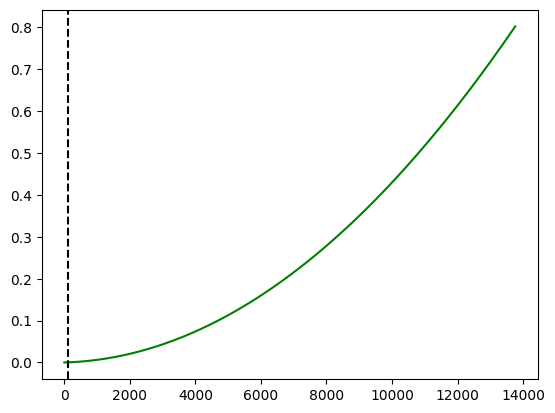

In [4]:
#testing with functions

tau_domain = np.linspace(1, tau_0, 10000)

a = (np.vectorize(a_RDMD))(tau_domain)
H = (np.vectorize(curly_H))(tau_domain)

#derivative test:
# a = np.vectorize(a_turner)(tau_domain)
# H_num = (np.gradient(a, tau_domain)) / (a)

plt.plot(tau_domain, a, c = "g")
# plt.plot(tau_domain, H, c = "b")
plt.axvline(tau_eq, color = "black", linestyle = "dashed")
# plt.axvline(tau_0, color = "black", linestyle = "dashed")


In [53]:
#horizon crossing calculations
# print("known:", tau_eq)

#use this!
def hc_H(k): #calc h.c. time for k using curlyH = k
    eq = lambda tau: curly_H(tau) - k
    return scipy.optimize.fsolve(eq, 0.001)[0]
def hc_H_inv(tau): #calc. k s.t. h.c. time for k is tau
    return curly_H(tau)

# def hc_tau(k): #calc h.c. time for k using k*tau = 1
#     return (1 / k)

k_try = k_eq

print(hc_H_inv(tau_0))


1.0730999999999998e-05
186112.27852866103
0.00014270725323580144


In [66]:
#attempt at calculating transfer function

# #transfer function, expected
def transfer_exp(k):
    a = (3 * scipy.special.spherical_jn(1, k * tau_0) / (k * tau_0))
    b = math.sqrt(1 + 1.36*(k / k_eq) + 2.5*((k / k_eq)**2))
    return a * b

def transfer_nobes(k):
    return math.sqrt(1 + 1.36*(k / k_eq) + 2.5*((k / k_eq)**2))

#helper for solve_ivp, specific to massless diff. eq.
def derivs(k): #pass in k to use
    def wrapper(tau, y):
        a = y[0]
        b = y[1]
        return [b, -2 * curly_H(tau) * b - a * (k**2)]
    return wrapper

def transfer_num(k):
    taus = np.linspace(1, tau_0, 2) #only need 2 points technically lol
    #derivs given above, y0 has 1 for init h_k and 0 for h_k'
    sols = scipy.integrate.solve_ivp(derivs(k), t_span = [taus[0], taus[-1]], y0 = [1, 0], t_eval = taus)
    bessel = (3 * scipy.special.spherical_jn(1, k * tau_0) / (k * tau_0))
    no_bes = sols.y[0][-1] / a
    return (no_bes if (no_bes < 2.2) else 0)

# k_dom = np.linspace(0.01 * k_eq, k_eq, 1000)
k_dom = np.linspace(hc_H_inv(tau_0), k_eq, 1000)
t_num = (np.vectorize(transfer_num))(k_dom)
t_exp = (np.vectorize(transfer_nobes))(k_dom)

plt.plot(k_dom, t_exp, c = "g")
plt.plot(k_dom, t_num, c = "r")
plt.axvline(k_eq, color = "blue", linestyle = "dashed")
    

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()